In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from datetime import datetime, timedelta

In [2]:
wego = pd.read_csv('../data/headway_data_with_datetimes.csv')
wego.head(1)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,CORRECTED_TRIP_ID,ROUTE_NUMBER,ARRIVAL_STATUS
0,120230801,1,99457890,2023-08-01,BORDEAUX,2200,1040,345104,0,TO DOWNTOWN,...,0,1,0,0.0,0,2,6.5,2023-08-01 - 345104,22,ON TIME


In [3]:
wego['CORRECTED_TRIP_ID'] = wego['CORRECTED_TRIP_ID'].astype(str) + '-' + wego['OVERLOAD_ID'].astype(str)

#### Counting and removing na values

In [4]:
#wego['ACTUAL_ARRIVAL_TIME'].isna().sum()

In [5]:
#wego['ADHERENCE'].isna().sum()

In [6]:
#wego_drop = wego.dropna(subset=['ADHERENCE'])

In [7]:
#wego_drop = wego.dropna(subset=['ACTUAL_ARRIVAL_TIME'])

In [8]:
#wego_drop['ADHERENCE'].isna().sum()

#### Convert time fields to DATETIME

In [9]:
wego['SCHEDULED_TIME']=pd.to_datetime(wego['SCHEDULED_TIME'])
wego['ACTUAL_ARRIVAL_TIME']=pd.to_datetime(wego['ACTUAL_ARRIVAL_TIME'])
wego['ACTUAL_DEPARTURE_TIME']=pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME'])

In [10]:
wego['LAYOVER'] = wego['ACTUAL_DEPARTURE_TIME'] - wego['ACTUAL_ARRIVAL_TIME']

In [11]:
wego['LAYOVER'] = wego['LAYOVER'].dt.total_seconds()/60

In [12]:
wego = wego.dropna(subset=['LAYOVER'])

In [13]:
wego['LAYOVER'] = wego['LAYOVER'].astype(int)

In [14]:
wego.dtypes

CALENDAR_ID                           int64
SERVICE_ABBR                          int64
ADHERENCE_ID                          int64
DATE                                 object
ROUTE_ABBR                           object
BLOCK_ABBR                            int64
OPERATOR                              int64
TRIP_ID                               int64
OVERLOAD_ID                           int64
ROUTE_DIRECTION_NAME                 object
TIME_POINT_ABBR                      object
ROUTE_STOP_SEQUENCE                 float64
TRIP_EDGE                             int64
LATITUDE                            float64
LONGITUDE                           float64
SCHEDULED_TIME               datetime64[ns]
ACTUAL_ARRIVAL_TIME          datetime64[ns]
ACTUAL_DEPARTURE_TIME        datetime64[ns]
ADHERENCE                           float64
SCHEDULED_HDWY                      float64
ACTUAL_HDWY                         float64
HDWY_DEV                            float64
ADJUSTED_EARLY_COUNT            

In [15]:
wego[['ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','LAYOVER']]

,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,LAYOVER
0,2023-08-01 04:37:38,2023-08-01 04:44:08,6
1,2023-08-01 04:48:27,2023-08-01 04:48:27,0
2,2023-08-01 04:54:56,2023-08-01 04:54:56,0
3,2023-08-01 05:03:43,2023-08-01 05:03:43,0
4,2023-08-01 05:03:43,2023-08-01 05:16:35,12
...,...,...,...
350323,2023-09-30 22:31:26,2023-09-30 22:31:26,0
350324,2023-09-30 22:49:18,2023-09-30 22:49:18,0
350325,2023-09-30 22:49:19,2023-09-30 22:49:19,0
350326,2023-09-30 23:21:05,2023-09-30 23:21:05,0


In [16]:
trip_1 = wego[['DATE','OPERATOR','TRIP_ID','CORRECTED_TRIP_ID','TRIP_EDGE','ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','LAYOVER','ADHERENCE','DWELL_IN_MINS']]
trip_1 = trip_1[trip_1['TRIP_EDGE']== 1]
trip_1.head()

,DATE,OPERATOR,TRIP_ID,CORRECTED_TRIP_ID,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,LAYOVER,ADHERENCE,DWELL_IN_MINS
0,2023-08-01,1040,345104,2023-08-01 - 345104-0,1,2023-08-01 04:37:38,2023-08-01 04:44:08,6,-2.133333,6.500000
4,2023-08-01,1040,345105,2023-08-01 - 345105-0,1,2023-08-01 05:03:43,2023-08-01 05:16:35,12,-1.583333,12.866666
7,2023-08-01,1040,345106,2023-08-01 - 345106-0,1,2023-08-01 05:30:30,2023-08-01 05:43:43,13,-1.716666,13.216666
11,2023-08-01,1040,345107,2023-08-01 - 345107-0,1,2023-08-01 06:05:31,2023-08-01 06:16:19,10,-1.316666,10.800000
14,2023-08-01,1040,345108,2023-08-01 - 345108-0,1,2023-08-01 06:30:59,2023-08-01 06:43:31,12,-1.516666,12.533333


In [17]:
trip_2 = wego[['DATE','OPERATOR','TRIP_ID','CORRECTED_TRIP_ID','TRIP_EDGE','ACTUAL_ARRIVAL_TIME','ACTUAL_DEPARTURE_TIME','LAYOVER','ADHERENCE','DWELL_IN_MINS']]
trip_2 = trip_2[trip_2['TRIP_EDGE']== 2]
trip_2.head()

,DATE,OPERATOR,TRIP_ID,CORRECTED_TRIP_ID,TRIP_EDGE,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,LAYOVER,ADHERENCE,DWELL_IN_MINS
3,2023-08-01,1040,345104,2023-08-01 - 345104-0,2,2023-08-01 05:03:43,2023-08-01 05:03:43,0,6.283333,0.0
6,2023-08-01,1040,345105,2023-08-01 - 345105-0,2,2023-08-01 05:30:30,2023-08-01 05:30:30,0,1.500000,0.0
10,2023-08-01,1040,345106,2023-08-01 - 345106-0,2,2023-08-01 06:05:31,2023-08-01 06:05:31,0,4.483333,0.0
13,2023-08-01,1040,345107,2023-08-01 - 345107-0,2,2023-08-01 06:30:59,2023-08-01 06:30:59,0,4.016666,0.0
17,2023-08-01,1040,345108,2023-08-01 - 345108-0,2,2023-08-01 07:05:49,2023-08-01 07:05:49,0,4.183333,0.0


In [18]:
first_last_adherence = pd.merge(trip_1, trip_2, on=['CORRECTED_TRIP_ID'], how='inner')
first_last_adherence.head()

,DATE_x,OPERATOR_x,TRIP_ID_x,CORRECTED_TRIP_ID,TRIP_EDGE_x,ACTUAL_ARRIVAL_TIME_x,ACTUAL_DEPARTURE_TIME_x,LAYOVER_x,ADHERENCE_x,DWELL_IN_MINS_x,DATE_y,OPERATOR_y,TRIP_ID_y,TRIP_EDGE_y,ACTUAL_ARRIVAL_TIME_y,ACTUAL_DEPARTURE_TIME_y,LAYOVER_y,ADHERENCE_y,DWELL_IN_MINS_y
0,2023-08-01,1040,345104,2023-08-01 - 345104-0,1,2023-08-01 04:37:38,2023-08-01 04:44:08,6,-2.133333,6.500000,2023-08-01,1040,345104,2,2023-08-01 05:03:43,2023-08-01 05:03:43,0,6.283333,0.0
1,2023-08-01,1040,345105,2023-08-01 - 345105-0,1,2023-08-01 05:03:43,2023-08-01 05:16:35,12,-1.583333,12.866666,2023-08-01,1040,345105,2,2023-08-01 05:30:30,2023-08-01 05:30:30,0,1.500000,0.0
2,2023-08-01,1040,345106,2023-08-01 - 345106-0,1,2023-08-01 05:30:30,2023-08-01 05:43:43,13,-1.716666,13.216666,2023-08-01,1040,345106,2,2023-08-01 06:05:31,2023-08-01 06:05:31,0,4.483333,0.0
3,2023-08-01,1040,345107,2023-08-01 - 345107-0,1,2023-08-01 06:05:31,2023-08-01 06:16:19,10,-1.316666,10.800000,2023-08-01,1040,345107,2,2023-08-01 06:30:59,2023-08-01 06:30:59,0,4.016666,0.0
4,2023-08-01,1040,345108,2023-08-01 - 345108-0,1,2023-08-01 06:30:59,2023-08-01 06:43:31,12,-1.516666,12.533333,2023-08-01,1040,345108,2,2023-08-01 07:05:49,2023-08-01 07:05:49,0,4.183333,0.0


In [19]:
first_last_adherence.drop(columns=['DATE_y','OPERATOR_y','TRIP_ID_y','TRIP_EDGE_y', 'ACTUAL_ARRIVAL_TIME_y','ACTUAL_ARRIVAL_TIME_x', 'TRIP_EDGE_x', 'ACTUAL_ARRIVAL_TIME_y','ACTUAL_DEPARTURE_TIME_x','ACTUAL_ARRIVAL_TIME_y','LAYOVER_y', 'DWELL_IN_MINS_y','ACTUAL_DEPARTURE_TIME_y'], axis = 1, inplace=True)
first_last_adherence.head()

,DATE_x,OPERATOR_x,TRIP_ID_x,CORRECTED_TRIP_ID,LAYOVER_x,ADHERENCE_x,DWELL_IN_MINS_x,ADHERENCE_y
0,2023-08-01,1040,345104,2023-08-01 - 345104-0,6,-2.133333,6.500000,6.283333
1,2023-08-01,1040,345105,2023-08-01 - 345105-0,12,-1.583333,12.866666,1.500000
2,2023-08-01,1040,345106,2023-08-01 - 345106-0,13,-1.716666,13.216666,4.483333
3,2023-08-01,1040,345107,2023-08-01 - 345107-0,10,-1.316666,10.800000,4.016666
4,2023-08-01,1040,345108,2023-08-01 - 345108-0,12,-1.516666,12.533333,4.183333


In [20]:
first_last_adherence = first_last_adherence.rename(columns={'DATE_x': 'DATE', 'OPERATOR_x': 'OPERATOR','TRIP_ID_x':'TRIP_ID','LAYOVER_x':'FIRST_LAYOVER','ADHERENCE_x':'FIRST_ADHERENCE','DWELL_IN_MINS_x':'FIRST_DWELL','ADHERENCE_y':'LAST_ADHERENCE'})
first_last_adherence = first_last_adherence[first_last_adherence['FIRST_DWELL']>=0].copy()
first_last_adherence.head(5)

,DATE,OPERATOR,TRIP_ID,CORRECTED_TRIP_ID,FIRST_LAYOVER,FIRST_ADHERENCE,FIRST_DWELL,LAST_ADHERENCE
0,2023-08-01,1040,345104,2023-08-01 - 345104-0,6,-2.133333,6.500000,6.283333
1,2023-08-01,1040,345105,2023-08-01 - 345105-0,12,-1.583333,12.866666,1.500000
2,2023-08-01,1040,345106,2023-08-01 - 345106-0,13,-1.716666,13.216666,4.483333
3,2023-08-01,1040,345107,2023-08-01 - 345107-0,10,-1.316666,10.800000,4.016666
4,2023-08-01,1040,345108,2023-08-01 - 345108-0,12,-1.516666,12.533333,4.183333


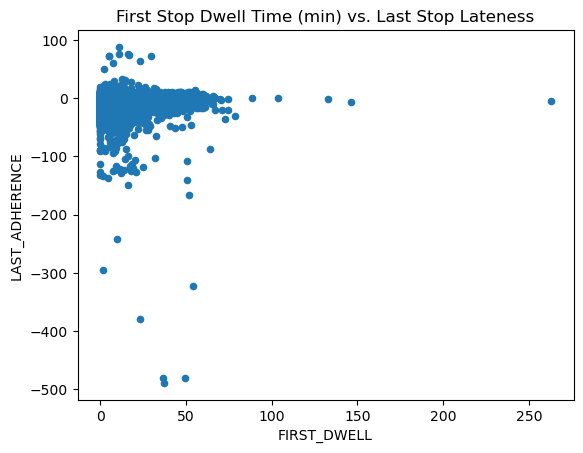

In [26]:
first_last_adherence.plot(kind = 'scatter', x = 'FIRST_DWELL', y = 'LAST_ADHERENCE')
plt.title('First Stop Dwell Time (min) vs. Last Stop Lateness');

In [38]:
r = first_last_adherence[['FIRST_DWELL', 'LAST_ADHERENCE']].corr()['FIRST_DWELL']['LAST_ADHERENCE']
print('r = ' + str(r))
print('R^2 = ' + str(r**2))

r = 0.10127870679835801
R^2 = 0.01025737645074777


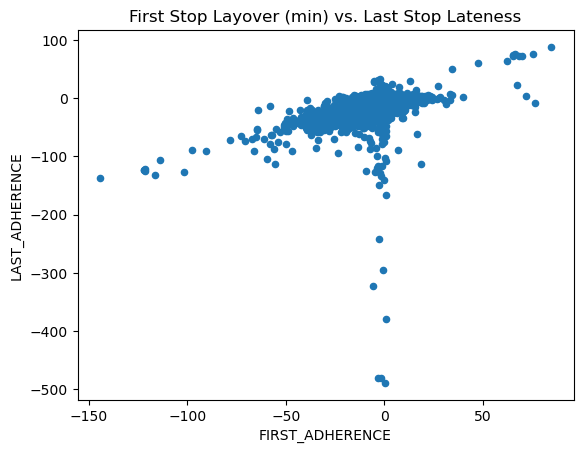

In [27]:
first_last_adherence.plot(kind = 'scatter', x = 'FIRST_ADHERENCE', y = 'LAST_ADHERENCE')
plt.title('First Stop Layover (min) vs. Last Stop Lateness');

In [39]:
r = first_last_adherence[['FIRST_ADHERENCE', 'LAST_ADHERENCE']].corr()['FIRST_ADHERENCE']['LAST_ADHERENCE']
print('r = ' + str(r))
print('R^2 = ' + str(r**2))

r = 0.4538638926489432
R^2 = 0.20599243305045145


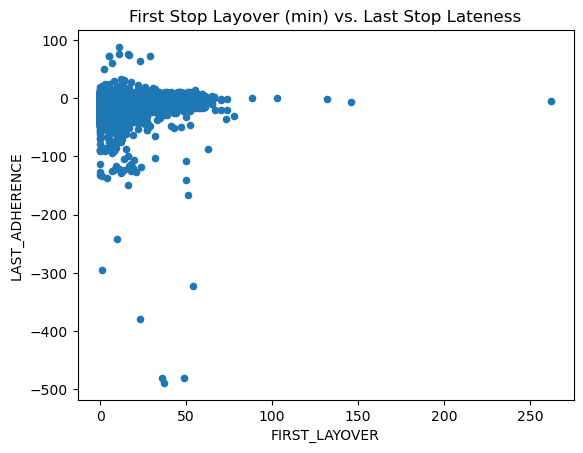

In [42]:
first_last_adherence.plot(kind = 'scatter', x = 'FIRST_LAYOVER', y = 'LAST_ADHERENCE')
plt.title('First Stop Layover (min) vs. Last Stop Lateness');

In [31]:
first_last_adherence_no_out = first_last_adherence[(first_last_adherence['FIRST_LAYOVER']<100) & (first_last_adherence['LAST_ADHERENCE']>-200)]

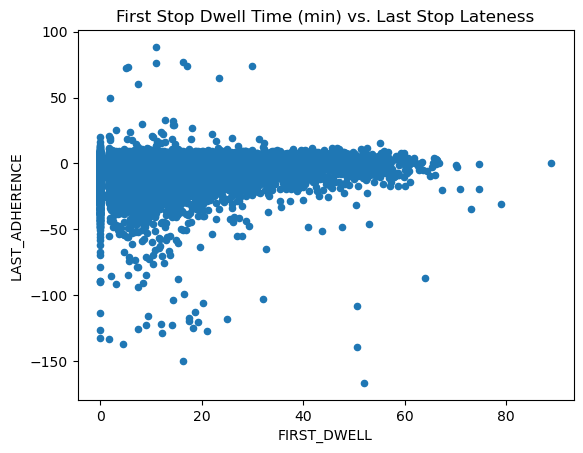

In [32]:
first_last_adherence_no_out.plot(kind = 'scatter', x = 'FIRST_DWELL', y = 'LAST_ADHERENCE')
plt.title('First Stop Dwell Time (min) vs. Last Stop Lateness');

In [35]:
r = first_last_adherence_no_out[['FIRST_DWELL', 'LAST_ADHERENCE']].corr()['FIRST_DWELL']['LAST_ADHERENCE']
print('r = ' + str(r))
print('R^2 = ' + str(r**2))

r = 0.13046188237180179
R^2 = 0.017020302751993847


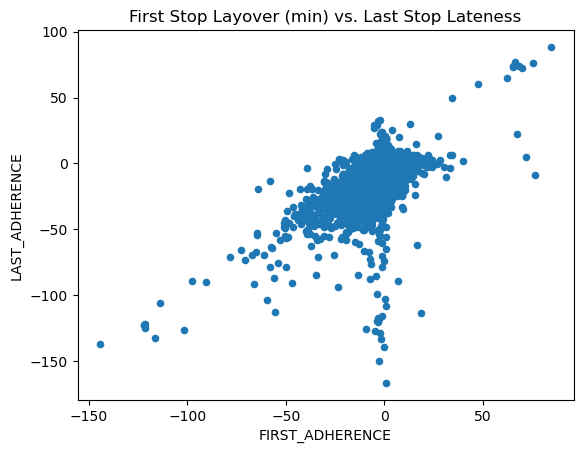

In [40]:
first_last_adherence_no_out.plot(kind = 'scatter', x = 'FIRST_ADHERENCE', y = 'LAST_ADHERENCE')
plt.title('First Stop Layover (min) vs. Last Stop Lateness');

In [41]:
r = first_last_adherence_no_out[['FIRST_ADHERENCE', 'LAST_ADHERENCE']].corr()['FIRST_ADHERENCE']['LAST_ADHERENCE']
print('r = ' + str(r))
print('R^2 = ' + str(r**2))

r = 0.5228857578942757
R^2 = 0.2734095158086711


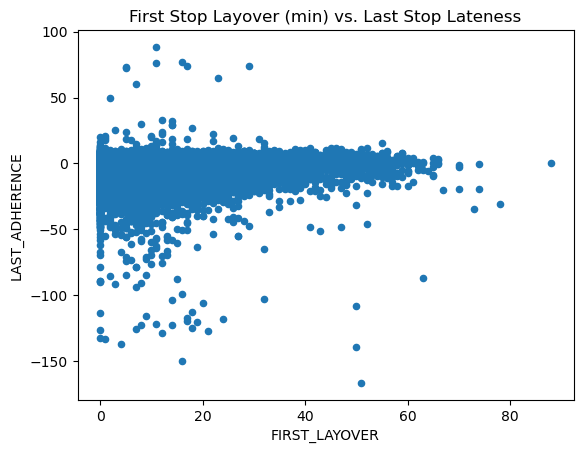

In [43]:
first_last_adherence_no_out.plot(kind = 'scatter', x = 'FIRST_LAYOVER', y = 'LAST_ADHERENCE')
plt.title('First Stop Layover (min) vs. Last Stop Lateness');

In [44]:
r = first_last_adherence_no_out[['FIRST_LAYOVER', 'LAST_ADHERENCE']].corr()['FIRST_LAYOVER']['LAST_ADHERENCE']
print('r = ' + str(r))
print('R^2 = ' + str(r**2))

r = 0.13000978681491385
R^2 = 0.016902544667659346
